In [18]:
from nltk.corpus import treebank
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import nltk
import json
import os
from collections import defaultdict

In [19]:
def get_user_name(url):
    parts = url.split('/')
    fname = parts[-1]
    uname = fname.rstrip('_log.csv')
    return uname


In [20]:
#combine all 'State' and 'Action' fields to a single dataframe making each as a string
#make array like this and add to that [('Pierre', 'NNP'),
from nltk.tag import hmm

# tagged_sentence = []
# hyperparam_file='sampled-hyperparameters-config.json'
# with open(hyperparam_file) as f:
#         hyperparams = json.load(f)
# threshold = hyperparams['threshold'][1:len(hyperparams['threshold'])-1]

# threshold = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]



interaction_file_path_movies= { 'p4': np.sort(glob.glob("data/zheng/processed_interactions_p4/*")),
                                 'p3': np.sort(glob.glob("data/zheng/processed_interactions_p3/*")),
                                 'p2': np.sort(glob.glob("data/zheng/processed_interactions_p2/*")),
                                    'p1': np.sort(glob.glob("data/zheng/processed_interactions_p1/*"))
                }

interaction_file_path_birdstrikes= { 'p4': np.sort(glob.glob("data/zheng/birdstrikes_processed_interactions_p4/*")),
                                    'p3': np.sort(glob.glob("data/zheng/birdstrikes_processed_interactions_p3/*")),
                                    'p2': np.sort(glob.glob("data/zheng/birdstrikes_processed_interactions_p2/*")),
                                        'p1': np.sort(glob.glob("data/zheng/birdstrikes_processed_interactions_p1/*"))
                }

save_path_movies ={ 'p4': 'Experiments_Folder/VizRec/movies/p4',
                    'p3': 'Experiments_Folder/VizRec/movies/p3',
                    'p2': 'Experiments_Folder/VizRec/movies/p2',
                    'p1': 'Experiments_Folder/VizRec/movies/p1'
                }

save_path_birdstikes ={ 'p4': 'Experiments_Folder/VizRec/birdstrikes/p4',
                    'p3': 'Experiments_Folder/VizRec/birdstrikes/p3',
                    'p2': 'Experiments_Folder/VizRec/birdstrikes/p2',
                    'p1': 'Experiments_Folder/VizRec/birdstrikes/p1'
                }


In [21]:

def leave_one_out_hmm(dataset, interaction_file_path_movies, save_path_movies):
    for task in [ 'p1', 'p2', 'p3', 'p4']:
        print('##################################### Processing task:', task)
        result_dataframe = pd.DataFrame()  # Create result DataFrame to store results for each task

        # Get the list of users in the current task
        user_list = interaction_file_path_movies[task]

        # Iterate over each user for leave-one-out cross-validation
        all_accuracy=[]

        for test_user in user_list:
            granular_prediction = defaultdict()


            # Load the test user data
            test_csv = pd.read_csv(test_user)
            test_tagged_sentence = [(str(test_csv['State'][i]), str(test_csv['Action'][i])) for i in range(len(test_csv['State']))]

            predicted_tags = []
            true_tags = []
            states = []

            # Leave-One-Out: Train on all users except the current one
            train_data = []
            for train_user in user_list:
                if train_user != test_user:
                    train_csv = pd.read_csv(train_user)
                    train_tagged_sentence = [(str(train_csv['State'][i]), str(train_csv['Action'][i])) for i in range(len(train_csv['State']))]
                    train_data.append(train_tagged_sentence)

            # Train the HMM model on the concatenated training data
            if train_data:
                train_data_flat = [item for sublist in train_data for item in sublist]  # Flatten the list of lists
                trainer = nltk.HiddenMarkovModelTagger.train([train_data_flat])

                # Test on the left-out test user
                insight = defaultdict(list)
                for state, true_tag in test_tagged_sentence:
                    try:
                        # Predict the tag for the current state
                        prediction = trainer.tag([state])
                        predicted_tag = prediction[0][1]
                    except ValueError:
                        print('Value Error during prediction for state:', state)
                        continue

                    predicted_tags.append(predicted_tag)
                    true_tags.append(true_tag)
                    insight[true_tag].append(1 if true_tag == predicted_tag else 0)
                    states.append(state)

                # Calculate accuracy
                if len(true_tags) > 0:
                    accuracy = np.mean(np.array(true_tags) == np.array(predicted_tags))
                else:
                    accuracy = 0  # No data to evaluate
                    print('No data to evaluate for user:', test_user)

                all_accuracy.append(accuracy)

                for keys, values in insight.items():
                    granular_prediction[keys] = (len(values), np.mean(values))



                # Store results for the current user
                name = get_user_name(test_user)
                data = {'User': name, 'Accuracy': accuracy, 'LearningRate': 0, 'Discount': 0, 'Algorithm': 'HMM', 'GranularPredictions': insight,'Predictions': str(predicted_tags) , 'GroundTruth':str(true_tags)}
                result_dataframe = pd.concat([result_dataframe, pd.DataFrame(data, index=[0])], ignore_index=True)
                del trainer  # Delete the trainer to free up memory

        # Save the results for the current task
        result_file_path = os.path.join(save_path_movies[task], 'HMM-Single-Model.csv')
        result_dataframe.to_csv(result_file_path, index=False)
        print( f'Dataset: {dataset}, Task: {task}, Average Accuracy: {np.mean(all_accuracy)}')
    return result_dataframe


In [22]:
result_dataframe=leave_one_out_hmm('movies',interaction_file_path_movies, save_path_movies)

##################################### Processing task: p1
Dataset: movies, Task: p1, Average Accuracy: 0.663839181927359
##################################### Processing task: p2
Dataset: movies, Task: p2, Average Accuracy: 0.24605938717910858
##################################### Processing task: p3
Dataset: movies, Task: p3, Average Accuracy: 0.25974325716754143
##################################### Processing task: p4
Dataset: movies, Task: p4, Average Accuracy: 0.27510607651032437


In [23]:
result_dataframe=leave_one_out_hmm('birdstrikes' ,interaction_file_path_birdstrikes, save_path_birdstikes)

##################################### Processing task: p1
Dataset: birdstrikes, Task: p1, Average Accuracy: 0.5379929817482758
##################################### Processing task: p2
Dataset: birdstrikes, Task: p2, Average Accuracy: 0.6268031094449591
##################################### Processing task: p3
Dataset: birdstrikes, Task: p3, Average Accuracy: 0.580765081995755
##################################### Processing task: p4
Dataset: birdstrikes, Task: p4, Average Accuracy: 0.26524993439508937


In [15]:
#for movies
movies_task_result_dataframe = pd.DataFrame()
for task in ['p1', 'p2', 'p3', 'p4']:
    #read the results
    result_file_path = os.path.join(save_path_movies[task], 'HMM-Single-Model.csv')
    task_results = pd.read_csv(result_file_path)
    print(f'Dataset: movies, Task: {task}, Average Accuracy: {task_results["Accuracy"].mean()}' )
    #store the results
    movies_task_result_dataframe = pd.concat([movies_task_result_dataframe, task_results], ignore_index=True)

#dataset average accuracy
print("Average Accuracy for all tasks is", movies_task_result_dataframe['Accuracy'].mean())


Dataset: movies, Task: p1, Average Accuracy: 0.663839181927359
Dataset: movies, Task: p2, Average Accuracy: 0.24605938717910858
Dataset: movies, Task: p3, Average Accuracy: 0.2597432571675414
Dataset: movies, Task: p4, Average Accuracy: 0.2751060765103243
Average Accuracy for all tasks is 0.36118697569608327


In [16]:
#for birdstrikes
birdstrikes_task_result_dataframe = pd.DataFrame()
for task in ['p1', 'p2', 'p3', 'p4']:
    #read the results
    result_file_path = os.path.join(save_path_birdstikes[task], 'HMM-Single-Model.csv')
    task_results = pd.read_csv(result_file_path)
    print(f'Dataset: birdstrikes, Task: {task}, Average Accuracy: {task_results["Accuracy"].mean()}' )
    #store the results
    birdstrikes_task_result_dataframe = pd.concat([birdstrikes_task_result_dataframe, task_results], ignore_index=True)
#dataset average accuracy
print("Average Accuracy for all tasks is", birdstrikes_task_result_dataframe['Accuracy'].mean())

Dataset: birdstrikes, Task: p1, Average Accuracy: 0.5379929817482758
Dataset: birdstrikes, Task: p2, Average Accuracy: 0.6268031094449591
Dataset: birdstrikes, Task: p3, Average Accuracy: 0.580765081995755
Dataset: birdstrikes, Task: p4, Average Accuracy: 0.26524993439508937
Average Accuracy for all tasks is 0.5027027768960198


In [17]:
#avergae for both datasets
print("Average Accuracy for both datasets is", (movies_task_result_dataframe['Accuracy'].mean()+birdstrikes_task_result_dataframe['Accuracy'].mean())/2)

Average Accuracy for both datasets is 0.43194487629605155


In [51]:
import pandas as pd

# Adjusted data
data = {
    'Model': [
        'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM', 'SVM',
        'Actor Critic', 'Actor Critic', 'Actor Critic', 'Actor Critic', 'Actor Critic', 'Actor Critic', 'Actor Critic', 'Actor Critic',
        'Q-Learning', 'Q-Learning', 'Q-Learning', 'Q-Learning', 'Q-Learning', 'Q-Learning', 'Q-Learning', 'Q-Learning',
        'SARSA', 'SARSA', 'SARSA', 'SARSA', 'SARSA', 'SARSA', 'SARSA', 'SARSA',
        'Greedy', 'Greedy', 'Greedy', 'Greedy', 'Greedy', 'Greedy', 'Greedy', 'Greedy',
        'Momentum', 'Momentum', 'Momentum', 'Momentum', 'Momentum', 'Momentum', 'Momentum', 'Momentum',
        'HMM', 'HMM', 'HMM', 'HMM', 'HMM', 'HMM', 'HMM', 'HMM'
    ],
    'Dataset': [
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes',
        'movies', 'movies', 'movies', 'movies', 'birdstrikes', 'birdstrikes', 'birdstrikes', 'birdstrikes'
    ],
    'Task': [
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4',
        'p1', 'p2', 'p3', 'p4', 'p1', 'p2', 'p3', 'p4'
    ],
    'Accuracy': [
        0.6280109147596199, 0.5821384048619673, 0.5585347533967872, 0.5536816177865722,
        0.5539855286385157, 0.6102205202704692, 0.5841938195641005, 0.5870893671095517,
        0.6879429756906157, 0.6385775088204831, 0.41740144641896015, 0.5440692264108838,
        0.5755724307890617, 0.6641451095417489, 0.5929944721184505, 0.6245992974142809,
        0.6939839501377428, 0.6455372949697513, 0.5504762092742103, 0.5633022414654927,
        0.5988599267217805, 0.6685443887701115, 0.5994557793238265, 0.6037536967200849,
        0.6856379315598238, 0.6350179982252152, 0.5557229548861216, 0.5534783670857009,
        0.5788096125482849, 0.6525756907397882, 0.5914099359001163, 0.5943296406829492,
        0.6650131173927929, 0.6143912775222425, 0.5083922257730772, 0.47338575995083726,
        0.5777183768440483, 0.6425990599725031, 0.5840080144090293, 0.546503258885337,
        0.5929342063228555, 0.5445210973734738, 0.538920189039184, 0.5484745952625161,
        0.5034000245562243, 0.5706171189222818, 0.5597919704877198, 0.5802923607438569,
        0.663839181927359, 0.24605938717910858, 0.2597432571675414, 0.2751060765103243,
        0.5379929817482758, 0.6268031094449591, 0.580765081995755, 0.26524993439508937
    ]
}

# Create DataFrame
df = pd.DataFrame(data)
print(df)


           Model      Dataset Task  Accuracy
0            SVM       movies   p1  0.628011
1            SVM       movies   p2  0.582138
2            SVM       movies   p3  0.558535
3            SVM       movies   p4  0.553682
4            SVM  birdstrikes   p1  0.553986
5            SVM  birdstrikes   p2  0.610221
6            SVM  birdstrikes   p3  0.584194
7            SVM  birdstrikes   p4  0.587089
8   Actor Critic       movies   p1  0.687943
9   Actor Critic       movies   p2  0.638578
10  Actor Critic       movies   p3  0.417401
11  Actor Critic       movies   p4  0.544069
12  Actor Critic  birdstrikes   p1  0.575572
13  Actor Critic  birdstrikes   p2  0.664145
14  Actor Critic  birdstrikes   p3  0.592994
15  Actor Critic  birdstrikes   p4  0.624599
16    Q-Learning       movies   p1  0.693984
17    Q-Learning       movies   p2  0.645537
18    Q-Learning       movies   p3  0.550476
19    Q-Learning       movies   p4  0.563302
20    Q-Learning  birdstrikes   p1  0.598860
21    Q-Le

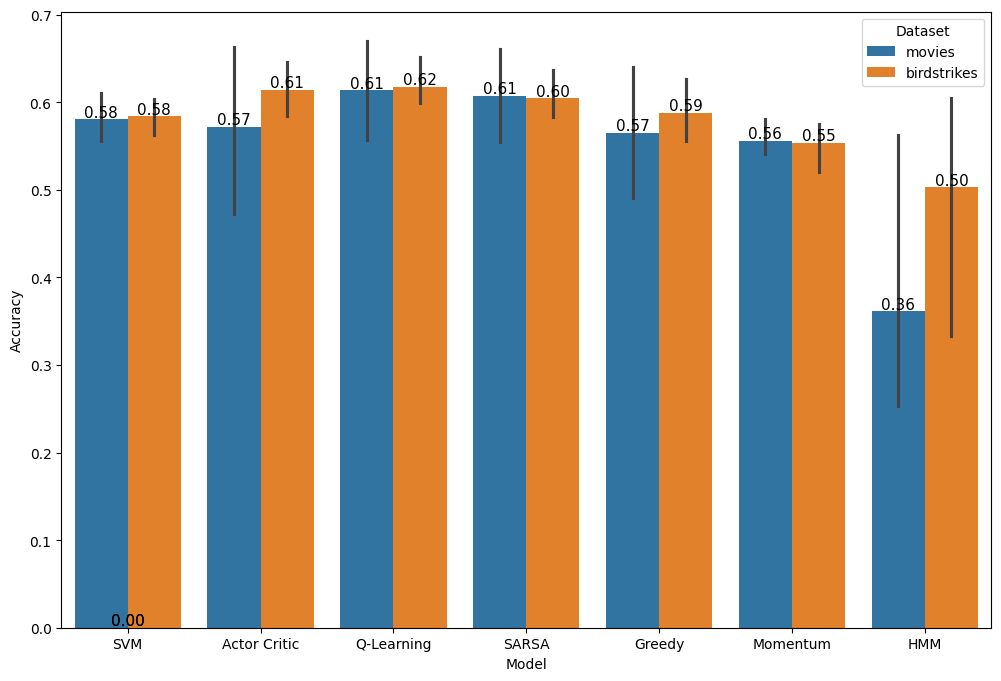

In [52]:
#plot
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 8))
#accuracy plot
sns.barplot(x='Model', y='Accuracy', hue='Dataset', data=df)
#add value to the plot
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')

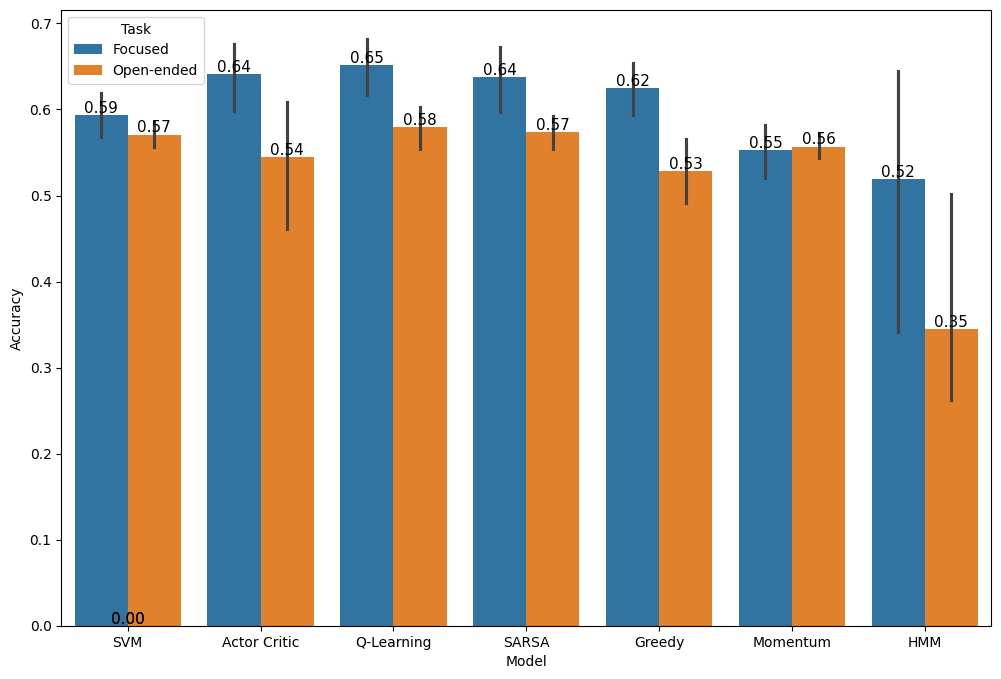

In [53]:
#make same plot but combining p1 and p2 as focused and p3 and p4 as nopenended tasks
df['Task'] = df['Task'].replace({'p1': 'Focused', 'p2': 'Focused', 'p3': 'Open-ended', 'p4': 'Open-ended'})
# Set the figure size
plt.figure(figsize=(12, 8))
#accuracy plot
sns.barplot(x='Model', y='Accuracy', hue='Task', data=df)
#add value to the plot
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                       textcoords='offset points')